# Load CIFAR-10 Dataset from FiftyOne

Import the CIFAR-10 dataset using FiftyOne's dataset zoo into Pixeltable tables.

**What's in this recipe:**
- Import CIFAR-10 dataset with images and classifications using FiftyOne
- Sample 1% of the training split (500 images from 50,000 total)
- Automatic schema handling for images and labels
- Work with image classification data in Pixeltable


## Problem

CIFAR-10 is a classic image classification dataset with 50,000 training images across 10 classes. You need a representative sample of this dataset in Pixeltable to apply AI models, create embeddings, or run analysis without downloading the entire dataset.


## Solution

**What's in this recipe:**
- Import 1% sample (500 images) from CIFAR-10 training split using FiftyOne
- Automatic schema handling for images and classification labels
- Work with 32x32 color images across 10 object classes

You can use FiftyOne's dataset zoo to efficiently download specific subsets of CIFAR-10, then import them into Pixeltable tables. This allows you to work with exactly the data you need.


### Setup


In [1]:
!uv add pixeltable fiftyone torch torchvision


Resolved 261 packages in 576ms                                       
⠙ Preparing packages... (0/1)                                                   ⠋ Preparing packages... (0/0)                                                   
⠙ Preparing packages... (0/1)--------------     0 B/1.80 MiB            
⠙ Preparing packages... (0/1)-------------- 16.00 KiB/1.80 MiB          
⠙ Preparing packages... (0/1)-------------- 32.00 KiB/1.80 MiB          
⠙ Preparing packages... (0/1)-------------- 48.00 KiB/1.80 MiB          
⠙ Preparing packages... (0/1)-------------- 61.94 KiB/1.80 MiB          
⠙ Preparing packages... (0/1)-------------- 77.94 KiB/1.80 MiB          
⠹ Preparing packages... (0/1)-------------- 93.94 KiB/1.80 MiB          
⠹ Preparing packages... (0/1)-------------- 93.94 KiB/1.80 MiB          
⠹ Preparing packages... (0/1)-------------- 109.94 KiB/1.80 MiB         
⠹ Preparing packages... (0/1)-------------- 125.94 KiB/1.80 MiB         
⠹ Preparing packages... (0/1)----------

In [2]:
import pixeltable as pxt
import fiftyone as fo
import fiftyone.zoo as foz


### Load CIFAR-10 Dataset from FiftyOne

Load the [CIFAR-10 dataset](https://docs.voxel51.com/dataset_zoo/datasets/cifar10.html) from FiftyOne's dataset zoo. We'll download 500 random samples from the training split (1% of 50,000 total training images).


In [3]:
# Load 500 random samples from CIFAR-10 training split (1% of 50,000)
cifar_dataset = foz.load_zoo_dataset(
    'cifar10',
    split='train',
    max_samples=500,
    shuffle=True
)

100%|██████████| 170M/170M [00:03<00:00, 44.3MB/s] 


 100% |█████████████| 50000/50000 [6.0s elapsed, 0s remaining, 7.4K samples/s]      
Dataset info written to '/Users/alison-pxt/fiftyone/cifar10/info.json'
Loading 'cifar10' split 'train'
 100% |█████████████████| 500/500 [75.7ms elapsed, 0s remaining, 6.6K samples/s]   
Dataset 'cifar10-train-500' created


In [4]:
# Create directory for CIFAR-10 data
pxt.drop_dir('cifar10_images', force=True)
pxt.create_dir('cifar10_images')


Connected to Pixeltable database at: postgresql+psycopg://postgres:@/pixeltable?host=/Users/alison-pxt/.pixeltable/pgdata
Created directory 'cifar10_images'.


### Create Pixeltable Table

Create a table and insert the sampled data. Each row contains a 32x32 color image with its class label.


In [5]:
# Create table with schema for images and labels
t = pxt.create_table(
    'cifar10_images.samples',
    schema={
        'image': pxt.Image,
        'label': pxt.String,
        'sample_id': pxt.Int
    },
    comment='Mini version of CIFAR-10 training split with 500 images from the FiftyOne dataset zoo.'
)


Created table 'samples'.


In [6]:
# Prepare rows for insertion from FiftyOne dataset
rows = []
for idx, sample in enumerate(cifar_dataset):
    # Extract label from ground_truth field
    label = sample.ground_truth.label if hasattr(sample, 'ground_truth') and sample.ground_truth else 'unknown'
    
    rows.append({
        'image': sample.filepath,
        'label': label,
        'sample_id': idx
    })

t.insert(rows)


Inserting rows into `samples`: 500 rows [00:00, 19685.84 rows/s]
Inserted 500 rows with 0 errors.


500 rows inserted, 1500 values computed.

In [9]:
t

table 'cifar10_images.samples'

 Column Name    Type Computed With
       image   Image              
       label  String              
   sample_id     Int              

COMMENT: Mini version of CIFAR-10 training split with 500 images from the FiftyOne dataset zoo.

image,label
,bird
,truck
,frog
,truck
,dog
,truck
,airplane
,bird
,ship
,automobile

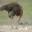
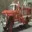
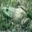
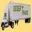
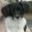
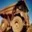
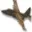
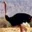
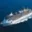
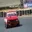

In [7]:
# View sample data
t.select(t.image, t.label).head(10)

### Extract Image Metadata

Add computed columns to extract metadata from the images.


In [11]:
# Add computed columns for image dimensions (should be 32x32 for CIFAR-10)
t.add_computed_column(width=t.image.width)
t.add_computed_column(height=t.image.height)

Added 500 column values with 0 errors.
Added 500 column values with 0 errors.


500 rows updated, 1000 values computed.

In [ ]:
# View images with their dimensions and labels
t.select(t.image, t.label, t.width, t.height).head(10)


In [8]:
# Check total count
t.count()

500

### Publish to Pixeltable Cloud

Publish the table to make it available on Pixeltable Cloud.


In [10]:
# Publish the table to Pixeltable Cloud
pxt.publish(
    'cifar10_images.samples',
    'pxt://pixeltable:fiftyone/cifar10_mini',
    access='public'
)

Creating a replica of 'cifar10_images.samples' at: pxt://pixeltable:fiftyone/cifar10_mini
Uploading: 100%|██████████████████████████████████████████████████| 396k/396k [00:00<00:00, 575kB/s]
Finalizing replica ...
The published table is now available at: pxt://pixeltable:fiftyone/cifar10_mini


In [12]:
t.push()

Creating a replica of 'cifar10_images.samples' at: pxt://pixeltable:fiftyone/2862aead-10d1-4b8f-b785-21ed9b502ea0
Uploading: 100%|██████████████████████████████████████████████████| 397k/397k [00:00<00:00, 682kB/s]
Finalizing replica ...
The published table is now available at: pxt://pixeltable:fiftyone/cifar10_mini


## See also

- [CIFAR-10 on FiftyOne Dataset Zoo](https://docs.voxel51.com/dataset_zoo/datasets/cifar10.html)
- [CIFAR-10 Dataset Website](https://www.cs.toronto.edu/~kriz/cifar.html)
